Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/15/nmt_attention_torch.ipynb

<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks-d2l/nmt_attention_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural machine translation using RNN with an attention-based decoder.

We show how to implement NMT  using an RNN with an attention-based decoder
Based on sec 10.4 of http://d2l.ai/chapter_attention-mechanisms/bahdanau-attention.html



     |████████████████████████████████| 184 kB 5.0 MB/s 
     |████████████████████████████████| 136 kB 42.8 MB/s 
     |████████████████████████████████| 72 kB 448 kB/s 


In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import math
from IPython import display

import jax

try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn
from flax.training import train_state

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

import collections
import re
import random
import os
import requests
import zipfile
import hashlib
import time
import functools

random.seed(0)
rng = jax.random.PRNGKey(0)

!mkdir figures # for saving plots

# Data downloading and preprocessing


In [3]:
# Required functions for downloading data


def download(name, cache_dir=os.path.join("..", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == ".zip":
        fp = zipfile.ZipFile(fname, "r")
    elif ext in (".tar", ".gz"):
        fp = tarfile.open(fname, "r")
    else:
        assert False, "Only zip/tar files can be extracted."
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [4]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = download_extract("fra-eng")
    with open(os.path.join(data_dir, "fra.txt"), "r") as f:
        return f.read()


def preprocess_nmt(text):
    """Preprocess the English-French dataset."""

    def no_space(char, prev_char):
        return char in set(",.!?") and prev_char != " "

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace("\u202f", " ").replace("\xa0", " ").lower()
    # Insert space between words and punctuation marks
    out = [" " + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    return "".join(out)


def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split("\n")):
        if num_examples and i > num_examples:
            break
        parts = line.split("\t")
        if len(parts) == 2:
            source.append(parts[0].split(" "))
            target.append(parts[1].split(" "))
    return source, target

In [5]:
class Vocab:
    """Vocabulary for text."""

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ["<unk>"] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [6]:
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
astype = lambda x, *args, **kwargs: jnp.array(x, *args, **kwargs)


def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab["<eos>"]] for l in lines]
    array = jnp.array([truncate_pad(l, num_steps, vocab["<pad>"]) for l in lines])
    valid_len = reduce_sum(astype(array != vocab["<pad>"], jnp.int32), 1)
    return array, valid_len

In [7]:
class Dataset:
    """A dataset wrapping data arrays."""

    def __init__(self, *data_arrays):
        self.arrays = data_arrays

    def __getitem__(self, indices):
        return tuple(array[jnp.array(indices)] for array in self.arrays)

    def __len__(self):
        return self.arrays[0].shape[0]


class DataLoader:
    """A data loader with an iterable for data arrays."""

    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __iter__(self):
        return self.data_iter()

    def data_iter(self):
        indices = list(range(0, len(self.dataset)))

        if self.shuffle:
            random.shuffle(indices)

        for i in range(0, len(indices), self.batch_size):
            yield self.dataset[indices[i : i + self.batch_size]]

In [8]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a data iterator."""
    dataset = Dataset(*data_arrays)
    return DataLoader(dataset, batch_size, shuffle=is_train)


def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))


def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=["<pad>", "<bos>", "<eos>"])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=["<pad>", "<bos>", "<eos>"])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [9]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

DATA_HUB["fra-eng"] = (DATA_URL + "fra-eng.zip", "94646ad1522d915e7b0f9296181140edcf86a4f5")

## GRU 

We create a multilayer GRU RNN. The hidden state of a layer, followed by dropout, is the input to the next layer.


In [10]:
class GRU(nn.Module):
    num_layers: int = 1
    dropout_rate: float = 0
    deterministic: bool = True

    @functools.partial(
        nn.transforms.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False, "dropout": True},
    )
    @nn.compact
    def __call__(self, state, x):
        new_states = []
        for i in range(self.num_layers - 1):
            new_state, x = nn.GRUCell()(state[i, :], x)
            new_states.append(new_state)
            x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=self.deterministic)
        # No dropout after the final layer
        new_state, output = nn.GRUCell()(state[-1, :], x)
        new_states.append(new_state)
        return jnp.array(new_states), output

    def initialize_carry(self, rng, batch_dims, size):
        return jnp.array([nn.GRUCell.initialize_carry(rng, batch_dims, size) for _ in range(self.num_layers)])

# Decoder

We define an abstract class for decoders that stores attention weights,
so we can visualize them.

In [11]:
class EncoderDecoder(nn.Module):
    """The encoder-decoder architecture."""

    encoder: nn.Module
    decoder: nn.Module

    @nn.compact
    def __call__(self, enc_X, dec_X, *args, deterministic=True):
        enc_outputs = self.encoder(enc_X, *args, deterministic=deterministic)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_state, dec_X, deterministic=deterministic)

Now we define the RNN+attention decoder. The state of the decoder is initialized with i) the encoder final-layer hidden states at all the time steps (as keys and values of the attention); ii) the encoder all-layer hidden state at the final time step (to initialize the hidden state of the decoder); and iii) the encoder valid length (to exclude the padding tokens in attention pooling). At each decoding time step, the decoder final-layer hidden state at the previous time step is used as the query of the attention. As a result, both the attention output and the input embedding are concatenated as the input of the RNN decoder. 

In [12]:
class Seq2SeqAttentionDecoder(nn.Module):
    vocab_size: int
    embed_size: int
    num_hiddens: int
    num_layers: int
    dropout_rate: float = 0.0

    def setup(self):
        self.attention = AdditiveAttention(
            key_size=self.num_hiddens,
            query_size=self.num_hiddens,
            num_hiddens=self.num_hiddens,
            dropout_rate=self.dropout_rate,
        )
        self.embedding = nn.Embed(num_embeddings=self.vocab_size, features=self.embed_size)
        self.dense = nn.Dense(features=self.vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        # Shape of `outputs`: (`num_steps`, `batch_size`, `num_hiddens`).
        hidden_state, outputs = enc_outputs
        return (hidden_state, outputs.transpose(1, 0, 2), enc_valid_lens, None)

    @nn.compact
    def __call__(self, state, X, deterministic=True):
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        hidden_state, enc_outputs, enc_valid_lens, _ = state
        # Shape of the output `X`: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).transpose(1, 0, 2)
        outputs, attention_weights_list = [], []
        rnn = GRU(num_layers=self.num_layers, dropout_rate=self.dropout_rate, deterministic=deterministic)
        for x in X:
            # Shape of `query`: (`batch_size`, 1, `num_hiddens`)
            query = jnp.expand_dims(hidden_state[-1], axis=1)
            # Shape of `context`: (`batch_size`, 1, `num_hiddens`)
            context, attention_weights = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens, deterministic=deterministic
            )
            # Concatenate on the feature dimension
            x = jnp.concatenate((context, jnp.expand_dims(x, axis=1)), axis=-1)
            # Reshape `x` as (1, `batch_size`, `embed_size` + `num_hiddens`)
            hidden_state, out = rnn(hidden_state, x.transpose(1, 0, 2))
            outputs.append(out)
            attention_weights_list.append(attention_weights)
        # After fully-connected layer transformation, shape of `outputs`:
        # (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense(jnp.concatenate(outputs, axis=0))
        return (hidden_state, enc_outputs, enc_valid_lens, attention_weights_list), outputs.transpose(1, 0, 2)


class AdditiveAttention(nn.Module):
    key_size: int
    query_size: int
    num_hiddens: int
    dropout_rate: float = 0.0

    def setup(self):
        self.W_q = nn.Dense(features=self.num_hiddens, use_bias=False)
        self.W_k = nn.Dense(features=self.num_hiddens, use_bias=False)
        self.w_v = nn.Dense(features=1, use_bias=False)
        self.dropout = nn.Dropout(rate=self.dropout_rate)

    @nn.compact
    def __call__(self, queries, keys, values, valid_lens, deterministic=True):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = jnp.expand_dims(queries, axis=2) + jnp.expand_dims(keys, axis=1)
        features = jnp.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return self.dropout(attention_weights, deterministic=deterministic) @ values, attention_weights

In [13]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D array, `valid_lens`: 1D or 2D array
    if valid_lens is None:
        return jax.nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if valid_lens.ndim == 1:
            valid_lens = jnp.repeat(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return jax.nn.softmax(X.reshape(shape), axis=-1)


def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = jnp.arange((maxlen))[None, :] < valid_len[:, None]
    return jnp.where(mask, X, value)

Example. Minibatch of 4 sequences of length 7.

In [14]:
class Seq2SeqEncoder(nn.Module):
    """The RNN encoder for sequence to sequence learning."""

    vocab_size: int
    embed_size: int
    num_hiddens: int
    num_layers: int = 1
    dropout_rate: float = 0.0

    @nn.compact
    def __call__(self, X, *args, deterministic=True):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = nn.Embed(num_embeddings=self.vocab_size, features=self.embed_size)(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.transpose(1, 0, 2)
        rnn = GRU(num_layers=self.num_layers, dropout_rate=self.dropout_rate, deterministic=deterministic)
        state = rnn.initialize_carry(jax.random.PRNGKey(0), (X.shape[1],), self.num_hiddens)
        state, output = rnn(state, X)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        return state, output

In [15]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
X = jnp.zeros((4, 7), dtype=jnp.int32)  # (`batch_size`, `num_steps`)
encoder_params = encoder.init(rng, X)
state = decoder.init_state(encoder.apply(encoder_params, X), None)
decoder_params = decoder.init(rng, state, X)
state, output = decoder.apply(decoder_params, state, X)
output.shape, len(state), state[1].shape, len(state[0]), state[0][0].shape

((4, 7, 10), 4, (4, 7, 16), 2, (4, 16))

# Training

In [16]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return jnp.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [17]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [18]:
@jax.jit
def grad_clipping(grads, theta):
    """Clip the gradient."""

    def grad_update(grads):
        return jax.tree_map(lambda g: g * theta / norm, grads)

    norm = jnp.sqrt(sum(jax.tree_util.tree_leaves(jax.tree_map(lambda x: jnp.sum(x**2), grads))))
    # Update gradient if norm > theta
    # This is jax.jit compatible
    grads = jax.lax.cond(norm > theta, grad_update, lambda g: g, grads)
    return grads

In [19]:
def masked_softmax_cross_entropy(pred, label, valid_len):
    """The softmax cross-entropy loss with masks."""

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    weights = jnp.ones(label.shape)
    weights = sequence_mask(weights, valid_len)
    label_one_hot = jax.nn.one_hot(label, num_classes=pred.shape[-1])
    unweighted_loss = optax.softmax_cross_entropy(pred, label_one_hot)
    weighted_loss = (unweighted_loss * weights).mean(axis=1)
    return weighted_loss

In [20]:
@jax.jit
def train_step(state, batch, bos_idx, rngs):
    """Train for a single step."""
    # Make sure to get a new RNG at every step
    step = state.step
    rngs = {name: jax.random.fold_in(rng, step) for name, rng in rngs.items()}

    def loss_fn(params):
        X, X_valid_len, Y, Y_valid_len = batch
        bos = jnp.array([bos_idx] * Y.shape[0]).reshape(-1, 1)
        dec_input = jnp.concatenate([bos, Y[:, :-1]], 1)  # Teacher forcing
        _, Y_hat = state.apply_fn({"params": params}, X, dec_input, X_valid_len, deterministic=False, rngs=rngs)
        loss = masked_softmax_cross_entropy(Y_hat, Y, Y_valid_len)
        return loss.sum()

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    grads = grad_clipping(grads, 1)
    state = state.apply_gradients(grads=grads)

    return state, loss

In [21]:
def train_seq2seq(state, data_iter, num_epochs, tgt_vocab, rngs):
    """Train a model for sequence to sequence."""
    animator = Animator(xlabel="epoch", ylabel="loss", xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            state, loss = train_step(state, batch, tgt_vocab["<bos>"], rngs)
            num_tokens = batch[3].sum()
            metric.add(loss, num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))

    device = jax.default_backend()
    print(f"loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} " f"tokens/sec on {device}")
    return state

In [22]:
def create_train_state(net, params, lr):
    """Create the train state for the network."""
    tx = optax.adam(learning_rate=lr)
    state = train_state.TrainState.create(apply_fn=net.apply, params=params, tx=tx)
    return state

# Learning curve

In [23]:
batch_size, num_steps = 64, 10

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

In [24]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
lr, num_epochs = 0.005, 250

params_rng, dropout_rng = jax.random.split(rng)
rngs = {"params": params_rng, "dropout": dropout_rng}

encoder = Seq2SeqEncoder(
    vocab_size=len(src_vocab),
    embed_size=embed_size,
    num_hiddens=num_hiddens,
    num_layers=num_layers,
    dropout_rate=dropout,
)
decoder = Seq2SeqAttentionDecoder(
    vocab_size=len(tgt_vocab),
    embed_size=embed_size,
    num_hiddens=num_hiddens,
    num_layers=num_layers,
    dropout_rate=dropout,
)
net = EncoderDecoder(encoder, decoder)

loss 0.020, 7162.5 tokens/sec on cpu


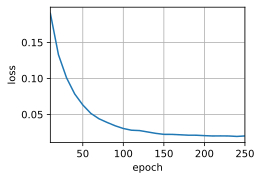

In [25]:
init_x = init_dec_input = jnp.ones((batch_size, num_steps), dtype=jnp.int32)
init_x_valid_len = jnp.ones((batch_size,), dtype=jnp.int32)
params = net.init(rngs, init_x, init_dec_input, init_x_valid_len)["params"]

state = create_train_state(net, params, lr)
# Set the seed for the data iterator
random.seed(0)
state = train_seq2seq(state, train_iter, num_epochs, tgt_vocab, rngs)

# Evaluation

In [26]:
def predict_seq2seq(net, state, src_sentence, src_vocab, tgt_vocab, num_steps, save_attention_weights=False):
    """Predict for sequence to sequence."""
    src_tokens = src_vocab[src_sentence.lower().split(" ")] + [src_vocab["<eos>"]]
    enc_valid_len = jnp.array([len(src_tokens)])
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab["<pad>"])
    # Add the batch axis
    enc_X = jnp.expand_dims(jnp.array(src_tokens, dtype=jnp.int32), axis=0)
    enc_outputs = net.encoder.apply({"params": state.params["encoder"]}, enc_X, enc_valid_len, deterministic=True)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = jnp.expand_dims(jnp.array([tgt_vocab["<bos>"]], dtype=jnp.int32), axis=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        dec_state, Y = net.decoder.apply({"params": state.params["decoder"]}, dec_state, dec_X, deterministic=True)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time stepz
        dec_X = Y.argmax(axis=2)
        pred = dec_X.squeeze(axis=0).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(dec_state[3])
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab["<eos>"]:
            break
        output_seq.append(pred)
    return " ".join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [27]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(" "), label_seq.split(" ")
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs["".join(label_tokens[i : i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs["".join(pred_tokens[i : i + n])] > 0:
                num_matches += 1
                label_subs["".join(pred_tokens[i : i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [28]:
engs = ["go .", "i lost .", "he's calm .", "i'm home ."]
fras = ["va !", "j'ai perdu .", "il est calme .", "je suis chez moi ."]
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, state, eng, src_vocab, tgt_vocab, num_steps, save_attention_weights=True
    )
    print(f"{eng} => {translation}, ", f"bleu {bleu(translation, fra, k=2):.3f}")

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il essaye .,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000


# Visualize attention weights

We apply the model to an input of length 4. The output has length 6. Thus the heatmap is 6x4. Unfortunately the result is not very interpretable, perhaps because the model was not trained well (small data, small time).

In [29]:
eng = engs[-1]  # length 3+1
fra = fras[-1]  # length 5+1

translation, dec_attention_weight_seq = predict_seq2seq(net, state, eng, src_vocab, tgt_vocab, num_steps, True)

attention_weights = jnp.concatenate([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape(
    (1, 1, -1, num_steps)
)

In [30]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap="Reds"):
    display.set_matplotlib_formats("svg")
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix, cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

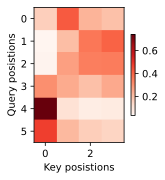

In [31]:
# Plus one to include the end-of-sequence token
show_heatmaps(
    attention_weights[:, :, :, : len(engs[-1].split()) + 1], xlabel="Key posistions", ylabel="Query posistions"
)